<a href="https://colab.research.google.com/github/YoheiFukuhara/nlp100-2020/blob/main/09.RNN%2CCNN/85_%E5%8F%8C%E6%96%B9%E5%90%91RNN%E3%83%BB%E5%A4%9A%E5%B1%A4%E5%8C%96.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

順方向と逆方向のRNNの両方を用いて入力テキストをエンコードし，モデルを学習せよ．

```math
\overleftarrow h_{T+1} = 0, \\
\overleftarrow h_t = {\rm \overleftarrow{RNN}}(\mathrm{emb}(x_t), \overleftarrow h_{t+1}), \\
y = {\rm softmax}(W^{(yh)} [\overrightarrow h_T; \overleftarrow h_1] + b^{(y)})
```

ただし，$\overrightarrow h_t \in \mathbb{R}^{d_h}, \overleftarrow h_t \in \mathbb{R}^{d_h}$はそれぞれ，順方向および逆方向のRNNで求めた時刻$t$の隠れ状態ベクトル，${\rm \overleftarrow{RNN}}(x,h)$は入力$x$と次時刻の隠れ状態$h$から前状態を計算するRNNユニット，$W^{(yh)} \in \mathbb{R}^{L \times 2d_h}$は隠れ状態ベクトルからカテゴリを予測するための行列，$b^{(y)} \in \mathbb{R}^{L}$はバイアス項である．また，$[a; b]$はベクトル$a$と$b$の連結を表す。

さらに，双方向RNNを多層化して実験せよ．

新しい記事
https://keras.io/examples/nlp/pretrained_word_embeddings/

少し古いがここの記事
https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

解説系記事
https://work-in-progress.hatenablog.com/entry/2019/03/03/122058

In [ ]:
import numpy as np
import nltk
from gensim.models import KeyedVectors
import pandas as pd
import tensorflow as tf
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


!python --version
!pip show numpy gensim google tensorflow nltk pandas

In [ ]:
BASE_PATH = '/content/drive/MyDrive/ColabNotebooks/ML/NLP100_2020/'
max_len = 0
vocabulary = []
w2v_model = KeyedVectors.load_word2vec_format(BASE_PATH+'07.WordVector/input/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [ ]:
def read_dataset(type_):
    global max_len
    global vocabulary
    df = pd.read_table(BASE_PATH+'06.MachineLearning/'+type_+'.feature.txt')
    df.info()
    sr_title = df['title'].str.split().explode()
    max_len_ = df['title'].map(lambda x: len(x.split())).max()
    if max_len < max_len_:
        max_len = max_len_
    if len(vocabulary) == 0:
        vocabulary = [k for k, v in nltk.FreqDist(sr_title).items() if v > 1]
    else:
        vocabulary.extend([k for k, v in nltk.FreqDist(sr_title).items() if v > 1])
    y = df['category'].replace({'b':0, 't':1, 'e':2, 'm':3})
    return df['title'], tf.keras.utils.to_categorical(y, dtype='int32')  # 4値分類なので訓練・検証・テスト共通でone-hot化

In [ ]:
X_train, y_train = read_dataset('train')
X_valid, y_valid = read_dataset('valid')
X_test, y_test = read_dataset('test') # あまりこだわらずにテストデータセットも追加

# setで重複削除し、タプル形式に設定
tup_voc = tuple(set(vocabulary))

print(f'vocabulary size before removing duplicates: {len(vocabulary)}')
print(f'vocabulary size after removing duplicates: {len(tup_voc)}')
print(f'sample vocabulary: {tup_voc[:10]}')
print(f'max length is {max_len}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10684 entries, 0 to 10683
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     10684 non-null  object
 1   category  10684 non-null  object
dtypes: object(2)
memory usage: 167.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1336 entries, 0 to 1335
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     1336 non-null   object
 1   category  1336 non-null   object
dtypes: object(2)
memory usage: 21.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1336 entries, 0 to 1335
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     1336 non-null   object
 1   category  1336 non-null   object
dtypes: object(2)
memory usage: 21.0+ KB
vocabulary size before removing duplicates: 11089
vocabulary size after removing duplicates: 7802
sa

In [ ]:
vectorize_layer = tf.keras.layers.TextVectorization(
 output_mode='int',
 vocabulary=tup_voc,
 output_sequence_length=max_len)

print(f'vocabulary size is {vectorize_layer.vocabulary_size()}')

vocabulary size is 7804


In [ ]:
voc = vectorize_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [ ]:
%%time
num_tokens = len(voc) + 2
embedding_dim = 300
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    try:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = w2v_model.get_vector(word)
        hits += 1
    except:
        misses += 1
        if misses < 7:
            print(word)
print("Converted %d words (%d misses)" % (hits, misses))


[UNK]
Bangerz
yellen
licence
f***e
Converted 7664 words (140 misses)
CPU times: user 34.6 ms, sys: 12 ms, total: 46.6 ms
Wall time: 46 ms


In [ ]:
embedding_layer = tf.keras.layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False
)

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)
model.add(embedding_layer)
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(50, return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(50)))
model.add(tf.keras.layers.Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 18)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 18, 300)           2341800   
                                                                 
 bidirectional_4 (Bidirectio  (None, 18, 100)          105600    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 100)              45600     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 4)                 404       
                                                      

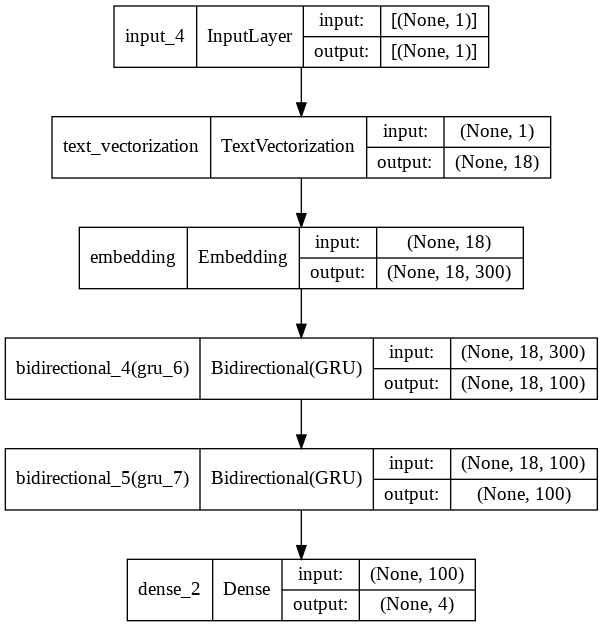

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
%%time
model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid))

Epoch 1/100
334/334 [==============================] - 24s 35ms/step - loss: 1.1814 - acc: 0.4495 - val_loss: 1.1166 - val_acc: 0.6677
Epoch 2/100
334/334 [==============================] - 9s 27ms/step - loss: 1.0690 - acc: 0.6760 - val_loss: 1.0134 - val_acc: 0.7081
Epoch 3/100
334/334 [==============================] - 9s 27ms/step - loss: 0.9237 - acc: 0.7149 - val_loss: 0.8403 - val_acc: 0.7268
Epoch 4/100
334/334 [==============================] - 9s 26ms/step - loss: 0.7768 - acc: 0.7368 - val_loss: 0.7444 - val_acc: 0.7507
Epoch 5/100
334/334 [==============================] - 9s 27ms/step - loss: 0.7146 - acc: 0.7480 - val_loss: 0.6990 - val_acc: 0.7485
Epoch 6/100
334/334 [==============================] - 9s 27ms/step - loss: 0.6856 - acc: 0.7540 - val_loss: 0.7055 - val_acc: 0.7395
Epoch 7/100
334/334 [==============================] - 9s 27ms/step - loss: 0.6662 - acc: 0.7600 - val_loss: 0.6613 - val_acc: 0.7620
Epoch 8/100
334/334 [==============================] - 9s 26m

In [ ]:
model.evaluate(X_test, y_test)

42/42 [==============================] - 1s 13ms/step - loss: 0.4558 - acc: 0.8391


[0.4558217525482178, 0.8390718698501587]